<a href="https://colab.research.google.com/github/NehaDalmia/CVND_Exercises/blob/master/DialogAct%20Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers==3.0.0

     |████████████████████████████████| 757kB 16.8MB/s 
     |████████████████████████████████| 1.1MB 27.2MB/s 
     |████████████████████████████████| 890kB 60.9MB/s 
     |████████████████████████████████| 3.0MB 55.6MB/s 


In [2]:
import transformers
from transformers import *
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import re
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!wget http://compprag.christopherpotts.net/code-data/swda.zip
!unzip swda.zip

--2020-12-23 06:05:54--  http://compprag.christopherpotts.net/code-data/swda.zip
Resolving compprag.christopherpotts.net (compprag.christopherpotts.net)... 64.90.36.20
Connecting to compprag.christopherpotts.net (compprag.christopherpotts.net)|64.90.36.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14040987 (13M) [application/zip]
Saving to: ‘swda.zip’

swda.zip            100%[===================>]  13.39M  17.2MB/s    in 0.8s    

2020-12-23 06:05:55 (17.2 MB/s) - ‘swda.zip’ saved [14040987/14040987]

Archive:  swda.zip
   creating: swda/
  inflating: swda/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/swda/
  inflating: __MACOSX/swda/._.DS_Store  
   creating: swda/sw00utt/
  inflating: swda/sw00utt/sw_0001_4325.utt.csv  
   creating: __MACOSX/swda/sw00utt/
  inflating: __MACOSX/swda/sw00utt/._sw_0001_4325.utt.csv  
  inflating: swda/sw00utt/sw_0002_4330.utt.csv  
  inflating: swda/sw00utt/sw_0003_4103.utt.csv  
  inflating: swda/sw00ut

In [4]:
!pwd
!ls 

def damsl_act_tag(act_tag):
  d_tags = []
  tags = re.split(r"\s*[,;]\s*", act_tag)
  for tag in tags:
    if tag in ('qy^d', 'qw^d', 'b^m'): pass
    elif tag == 'nn^e': tag = 'ng'
    elif tag == 'ny^e': tag = 'na'
    else: 
      tag = re.sub(r'(.)\^.*', r'\1', tag)
      tag = re.sub(r'[\(\)@*]', '', tag)            
      if tag in ('qr', 'qy'):                         tag = 'qy'
      elif tag in ('fe', 'ba'):                       tag = 'ba'
      elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
      elif tag in ('fx', 'sv'):                       tag = 'sv'
      elif tag in ('aap', 'am'):                      tag = 'aap_am'
      elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
      elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
    d_tags.append(tag)
  # Dan J says (p.c.) that it makes sense to take the first;
  # there are only a handful of examples with 2 tags here.
  return d_tags[0]

path = "swda/*" # use your path
all_files = glob.glob(path + "/*.csv")
# print(all_files)
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.head()
df = frame.filter(["text", "act_tag"], axis = 1)
df["act_tag"] = df["act_tag"].apply(lambda x : damsl_act_tag(x) )
df.head()

/content
__MACOSX  sample_data  swda  swda.zip


,text,act_tag
0,"<Beep> <breathing> {F Um, } what's our topic? /",qw
1,Taxes. /,sd
2,Taxes. /,sd
3,Do we pay too much? /,qy
4,Right. /,b


In [5]:
frame.head()

,swda_filename,ptb_basename,conversation_no,transcript_index,act_tag,caller,utterance_index,subutterance_index,text,pos,trees,ptb_treenumbers
0,sw00utt/sw_0077_4155.utt,4/sw4155,4155,0,qw,A,1,1,"<Beep> <breathing> {F Um, } what's our topic? /","Um/UH ,/, [ what/WP ] 's/BES [ our/PRP$ topi...","(SBARQ (INTJ (UH Um)) (, ,) (WHNP-1 (WP what))...",1
1,sw00utt/sw_0077_4155.utt,4/sw4155,4155,1,sd,B,2,1,Taxes. /,[ Taxes/NNS ] ./.,(NP (NNS Taxes) (. .) (-DFL- E_S)),3
2,sw00utt/sw_0077_4155.utt,4/sw4155,4155,2,sd^m,A,3,1,Taxes. /,[ Taxes/NNS ] ./.,(NP (NNS Taxes) (. .) (-DFL- E_S)),3
3,sw00utt/sw_0077_4155.utt,4/sw4155,4155,3,qy,B,4,1,Do we pay too much? /,Do/VBP [ we/PRP ] pay/VB too/RB much/RB ?/.,(SQ (VBP Do) (NP-SBJ (PRP we)) (VP (VB pay) (N...,7
4,sw00utt/sw_0077_4155.utt,4/sw4155,4155,4,b,A,5,1,Right. /,[ Right/UH ] ./.,(INTJ (UH Right) (. .) (-DFL- E_S)),9


text       223606
act_tag    223606
dtype: int64
(223606, 2)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


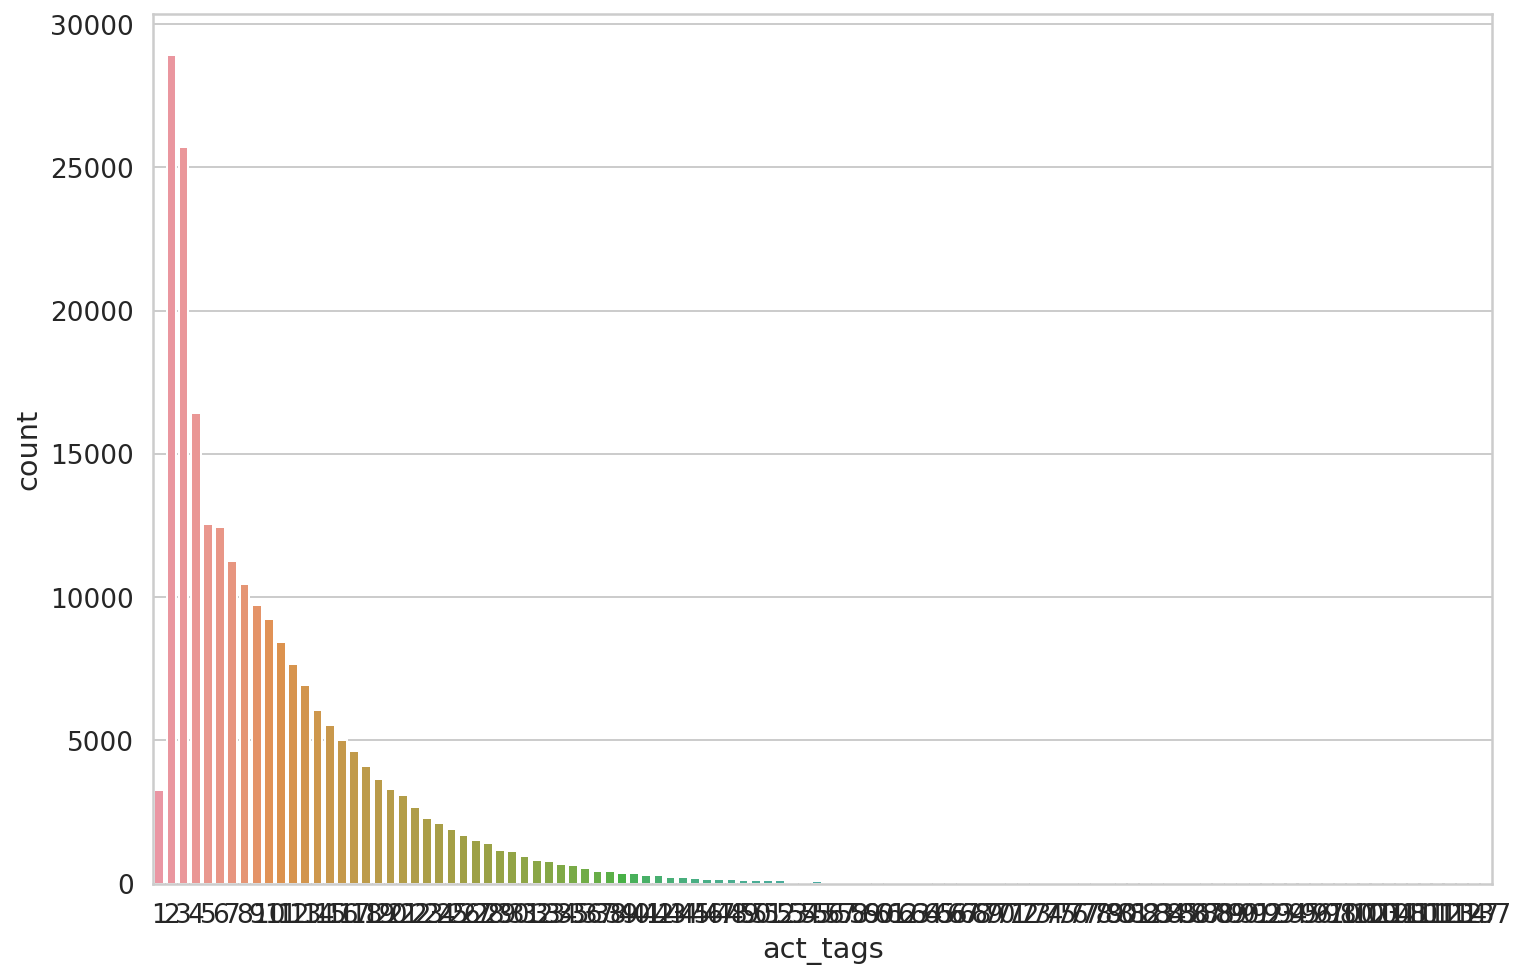

In [6]:
print(df.count())
print(df.shape)
sns.countplot(df.text.map(lambda x : len(x.split(" "))))
plt.xlabel('act_tags');

In [7]:
pd.options.display.max_colwidth=1000
df.loc[df.text.map(lambda x : len(x.split(" ")))==137]

,text,act_tag
121760,"{D You know, } {C but } I'm not convinced, [ [ that's, + [ a-, + ] tha-, ] + that ] Social Security is doing as well as it should [ [ [ [ [ [ {C and, } + {D you know, } {C and, } ] + {C and, } ] + {C and, } {F uh, } ] + {C and, } ] + {C and } ] that, {D you know, } those people who need it for welfare and so forth, who really need it for welfare, not the eighty-five to ninety percent of them who don't need it. But {E I mean } the real people who really need it, {D you know, } should be getting it /",sd


In [8]:
counts_text = df.text.map(lambda x : len(x.split(" "))).value_counts()
counts_text[:50]

2     28915
3     25705
4     16421
5     12570
6     12462
7     11247
8     10448
9      9737
10     9225
11     8423
12     7670
13     6919
14     6076
15     5545
16     5013
17     4613
18     4091
19     3661
20     3287
1      3253
21     3079
22     2663
23     2305
24     2113
25     1919
26     1697
27     1513
28     1419
29     1186
30     1125
31      972
32      830
33      790
34      674
35      657
36      541
38      455
37      447
39      385
40      353
42      301
41      297
43      240
44      223
45      206
47      174
46      167
48      145
50      129
49      128
Name: text, dtype: int64

In [9]:
counts_act = df.act_tag.value_counts()
print(counts_act)



sd                 75403
b                  38381
sv                 26527
+                  18691
%                  15682
aa                 11157
ba                  4797
qy                  4760
x                   3678
ny                  3040
fc                  2585
qw                  1990
nn                  1378
bk                  1309
h                   1227
fo_o_fw_"_by_bc     1222
qy^d                1217
bh                  1057
^q                   986
bf                   961
na                   851
ad                   752
^2                   730
b^m                  689
qo                   657
qh                   578
^h                   557
ar                   345
ng                   303
br                   299
no                   286
fp                   225
qrr                  210
arp_nd               207
t3                   117
oo_co_cc             110
aap_am               105
bd                   104
t1                   103
^g                    93


In [10]:
tags = ['fo_o_fw_"_by_bc', 'sd', 'b', '+', 'ba', 'sv', '%', 'aa', 'qy', 'nn', 'bf', 'qh', 'ad', 'qy^d', 'na', 'h', 'fc', 'qw', 'x', 'ng', 'ny', 'bh', '^h', '^2', 'b^m', 'bk', 'qo', 'aap_am', 'qrr', 'no', 'fa', 'bd', 'ar', 'br', 'ft', 'fp', '^q', 'arp_nd', 'qw^d', 't1', 't3', 'oo_co_cc', '^g']
print(len(tags))

43


In [11]:
tags.index("sd")

1

In [12]:
df.act_tag = df.act_tag.apply(lambda x : tags.index(x))
class_counts = df.act_tag.value_counts()
print(class_counts)

1     75403
2     38381
5     26527
3     18691
6     15682
7     11157
4      4797
8      4760
18     3678
20     3040
16     2585
17     1990
9      1378
25     1309
15     1227
0      1222
13     1217
21     1057
36      986
10      961
14      851
12      752
23      730
24      689
26      657
11      578
22      557
32      345
19      303
33      299
29      286
35      225
28      210
37      207
40      117
41      110
27      105
31      104
39      103
42       93
38       80
30       79
34       78
Name: act_tag, dtype: int64


In [13]:
class_weights = [max(class_counts)/class_counts[x] for x in range(len(class_counts))]
print(class_weights)

[61.70458265139116, 1.0, 1.9645918553450927, 4.034187576908673, 15.718782572441109, 2.8425000942436007, 4.80825149853335, 6.758357981536255, 15.840966386554621, 54.71915820029027, 78.4630593132154, 130.45501730103805, 100.26994680851064, 61.958093672966314, 88.60517038777908, 61.453137734311326, 29.16943907156673, 37.890954773869346, 20.501087547580205, 248.85478547854785, 24.803618421052633, 71.33680227057711, 135.3734290843806, 103.29178082191781, 109.43831640058055, 57.603514132925895, 114.76864535768645, 718.1238095238095, 359.06190476190477, 263.6468531468532, 954.4683544303797, 725.0288461538462, 218.55942028985507, 252.1839464882943, 966.7051282051282, 335.12444444444446, 76.473630831643, 364.2657004830918, 942.5375, 732.0679611650486, 644.4700854700855, 685.4818181818182, 810.7849462365591]


In [14]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')
utterances = {}
with open('/content/gdrive/My Drive/Colab Notebooks/Statement.txt', 'r') as of:
  temp = of.read()
indi = temp.split('\n')
for i in indi:
  spl = i.split('|')
  utterances[spl[1]]=spl[0]
utterances['x']='Unknown'
utterances['+']='Unknown'
print(utterances)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
{'sd': 'Statement-non-opinion', 'b': 'Acknowledge (Backchannel)', 'sv': 'Statement-opinion', '%': 'Uninterpretable', 'aa': 'Agree/Accept', 'ba': 'Appreciation', 'qy': 'Yes-No-Question', 'ny': 'Yes Answers', 'fc': 'Conventional-closing', 'qw': 'Wh-Question', 'nn': 'No Answers', 'bk': 'Response Acknowledgement', 'h': 'Hedge', 'qy^d': 'Declarative Yes-No-Question', 'bh': 'Backchannel in Question Form', '^q': 'Quotation', 'bf': 'Summarize/Reformulate', 'fo_o_fw_"_by_bc': 'Other', 'na': 'Affirmative Non-yes Answers', 'ad': 'Action-directive', '^2': 'Collaborative Completion', 'b^m': 'Repeat-phrase', 'qo': 'Open-Question', 'qh': 'Rhetorical-Question', '^h': 'Hold Before Answer/Agreement', 'ar': 'Reject', 'ng': 'Negative Non-no Answers', 'br': 'Signal-non-understanding', 'no': 'Other Answers', 'fp': 'Conventional-opening', 'qrr': 'Or-Clause', 'arp_nd': 'Dispreferr

In [18]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_txt = "Here is some text to encode"
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
print(encoding.keys())
# dict_keys(['input_ids', 'attention_mask'])
encoding['input_ids'][0]

# input_ids = torch.tensor([tokenizer.encode("Here is some text to encode", add_special_tokens=True)])  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
# with torch.no_grad():
#     last_hidden_states = model(input_ids)[0]

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


 Sentence: Here is some text to encode
   Tokens: ['Here', 'Ġis', 'Ġsome', 'Ġtext', 'Ġto', 'Ġencode']
Token IDs: [11773, 16, 103, 2788, 7, 46855]
dict_keys(['input_ids', 'attention_mask'])


tensor([    0, 11773,    16,   103,  2788,     7, 46855,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1])

In [19]:
MAX_LEN = 80

In [20]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True,
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [21]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)
df_train.shape, df_val.shape, df_test.shape

((201245, 2), (11180, 2), (11181, 2))

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.act_tag.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
data = next(iter(train_data_loader))
data.keys()
# next(iter(train_data_loader)).keys
# dummy = df.text.to_numpy()
# print(str(dummy[5]))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [24]:
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [25]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)
last_hidden_state.shape

torch.Size([1, 32, 768])

In [26]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [27]:
model = SentimentClassifier(len(tags))
model = model.to(device)

In [28]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 80])
torch.Size([16, 80])


In [29]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
class_weights_tensor = torch.FloatTensor(class_weights)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)

In [30]:
print(class_weights_tensor)

tensor([ 61.7046,   1.0000,   1.9646,   4.0342,  15.7188,   2.8425,   4.8083,
          6.7584,  15.8410,  54.7192,  78.4631, 130.4550, 100.2699,  61.9581,
         88.6052,  61.4531,  29.1694,  37.8910,  20.5011, 248.8548,  24.8036,
         71.3368, 135.3734, 103.2918, 109.4383,  57.6035, 114.7686, 718.1238,
        359.0619, 263.6469, 954.4684, 725.0289, 218.5594, 252.1839, 966.7051,
        335.1245,  76.4736, 364.2657, 942.5375, 732.0679, 644.4701, 685.4818,
        810.7850])


In [31]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  
  return correct_predictions.double() / n_examples, np.mean(losses)


In [33]:
"""#do not run this cell
#%%time
history = defaultdict(list)
best_accuracy = 0
rates= {2e-4}
for rate in rates:
  for epoch in range(EPOCHS):
    for param_group in optimizer.param_groups:
      param_group['lr']=rate
      print(param_group['lr'])
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc"""

"#do not run this cell\n#%%time\nhistory = defaultdict(list)\nbest_accuracy = 0\nrates= {2e-4}\nfor rate in rates:\n  for epoch in range(EPOCHS):\n    for param_group in optimizer.param_groups:\n      param_group['lr']=rate\n      print(param_group['lr'])\n    print(f'Epoch {epoch + 1}/{EPOCHS}')\n    print('-' * 10)\n    train_acc, train_loss = train_epoch(\n      model,\n      train_data_loader,\n      loss_fn,\n      optimizer,\n      device,\n      scheduler,\n      len(df_train)\n    )\n    print(f'Train loss {train_loss} accuracy {train_acc}')\n    val_acc, val_loss = eval_model(\n      model,\n      val_data_loader,\n      loss_fn,\n      device,\n      len(df_val)\n    )\n    print(f'Val   loss {val_loss} accuracy {val_acc}')\n    print()\n    history['train_acc'].append(train_acc)\n    history['train_loss'].append(train_loss)\n    history['val_acc'].append(val_acc)\n    history['val_loss'].append(val_loss)\n    if val_acc > best_accuracy:\n      torch.save(model.state_dict(), 

In [34]:
!ls "/content/gdrive/My Drive"

'101-opening (edited) (online-audio-converter.com).mp3'  'Neha Dalmia.gdoc'
 assignment2						 'Neha Dalmia.pdf'
 assignment3						  NextToMe.mp3
'Colab Notebooks'


In [35]:
''' !cp /content/best_model_state.bin "/content/gdrive/My Drive/Colab Notebooks" '''

' !cp /content/best_model_state.bin "/content/gdrive/My Drive/Colab Notebooks" '

In [36]:
model_save_name = 'best_model_state.bin'
path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [37]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.710312136660406

In [38]:
def get_predictions(model, data_loader, df1):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      acts = [tags[i] for i in preds]
      acts = [utterances[i] for i in acts]
      actst = [tags[i] for i in targets ]
      actst = [utterances[i] for i in actst]
      #utter = [utterance[i] for i in acts]
      #for i in acts:
        #utter.append(utterance[i])
        #print(i)
      df2 = pd.DataFrame([acts, actst, texts])
      df2=df2.T
      #print(len(texts))
      #print(df2.shape)
      #print(df1.shape)
      df1 = pd.concat([df1,df2], ignore_index=True)
      #print(df1.shape)
      #print("predictions",preds)
      #print("targets",targets)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values,df1

In [39]:
df1 = pd.DataFrame()
y_review_texts, y_pred, y_pred_probs, y_test,df3 = get_predictions(
  model,
  test_data_loader,
  df1
)
df3.columns=["Roberta Act prediction", "True Dataset Act", "Utterance"]
display(df3)

,Roberta Act prediction,True Dataset Act,Utterance
0,Statement-opinion,Statement-non-opinion,"{C and, } [ it's, + there's ] a lot of, {D you know, } [ the whole, + the whole ] department of defense, {F uh, } reasoning behind the original plan and whatnot. /"
1,Negative Non-no Answers,Statement-non-opinion,I don't think so. /
2,Acknowledge (Backchannel),Acknowledge (Backchannel),Uh-huh. /
3,Statement-opinion,Statement-opinion,"{C So, } {D you know, } that's just where I probably need to be a little more responsible, citizen wise, {D you know, } looking or searching those out because you figure if we as the citizens do that then the manufactures and producers will start packaging it that way. /"
4,Statement-non-opinion,Statement-non-opinion,"We are constantly, it seems like. /"
...,...,...,...
11176,Rhetorical-Question,Quotation,"is she having problems, /"
11177,Uninterpretable,Uninterpretable,"they, # -/"
11178,Yes Answers,Acknowledge (Backchannel),"yeah, /"
11179,Agree/Accept,Acknowledge (Backchannel),# <Laughter> Yeah. /


In [40]:
print(classification_report(y_test, y_pred, target_names= tags ))

                 precision    recall  f1-score   support

fo_o_fw_"_by_bc       0.23      0.48      0.31        61
             sd       0.91      0.68      0.78      3776
              b       0.90      0.67      0.77      1906
              +       0.81      0.82      0.82       939
             ba       0.78      0.80      0.79       280
             sv       0.58      0.75      0.65      1385
              %       0.77      0.86      0.81       749
             aa       0.40      0.62      0.48       540
             qy       0.89      0.86      0.87       244
             nn       0.57      0.99      0.72        74
             bf       0.17      0.36      0.23        50
             qh       0.60      0.48      0.53        25
             ad       0.65      0.79      0.71        33
           qy^d       0.43      0.46      0.45        50
             na       0.20      0.31      0.24        48
              h       0.57      0.81      0.67        68
             fc       0.72    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
result_compare = classification_report(y_test, y_pred, target_names= tags , output_dict=True )
for k in result_compare:
  try:
    print(k+","+str(result_compare[k]["precision"])+","+str(result_compare[k]["recall"])+","+str(result_compare[k]["f1-score"])+","+str(result_compare[k]["support"]))
  except:
    a =1

fo_o_fw_"_by_bc,0.23387096774193547,0.47540983606557374,0.3135135135135135,61
sd,0.9087033747779751,0.6774364406779662,0.7762099833105751,3776
b,0.8982456140350877,0.6715634837355718,0.7685379765836085,1906
+,0.8130939809926082,0.820021299254526,0.8165429480381761,939
ba,0.7804878048780488,0.8,0.7901234567901235,280
sv,0.5769656699889258,0.752346570397112,0.6530868066436855,1385
%,0.7685851318944844,0.855807743658211,0.8098547062539482,749
aa,0.3971631205673759,0.6222222222222222,0.4848484848484848,540
qy,0.8893617021276595,0.8565573770491803,0.8726513569937369,244
nn,0.5658914728682171,0.9864864864864865,0.7192118226600985,74
bf,0.16666666666666666,0.36,0.2278481012658228,50
qh,0.6,0.48,0.5333333333333332,25
ad,0.65,0.7878787878787878,0.7123287671232875,33
qy^d,0.4339622641509434,0.46,0.44660194174757284,50
na,0.2,0.3125,0.24390243902439027,48
h,0.5670103092783505,0.8088235294117647,0.6666666666666666,68
fc,0.7191011235955056,0.5565217391304348,0.627450980392157,115
qw,0.7631578947368

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
with open('/content/gdrive/My Drive/Colab Notebooks/dialogues_text.txt', 'r') as f:
    review_text = f.read()
context = review_text.split('__eou__')
'''
print(context)
dialogacts=[]
for text in context:
 encoded_review = tokenizer.encode_plus(
    text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    truncation = True,
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print(tags[prediction])
  dialogacts.append(tags[prediction])
for act in dialogacts:
  print(act)'''

"\nprint(context)\ndialogacts=[]\nfor text in context:\n encoded_review = tokenizer.encode_plus(\n    text,\n    max_length=MAX_LEN,\n    add_special_tokens=True,\n    return_token_type_ids=False,\n    pad_to_max_length=True,\n    return_attention_mask=True,\n    return_tensors='pt',\n    truncation = True,\n  )\n  input_ids = encoded_review['input_ids'].to(device)\n  attention_mask = encoded_review['attention_mask'].to(device)\n  output = model(input_ids, attention_mask)\n  _, prediction = torch.max(output, dim=1)\n  print(tags[prediction])\n  dialogacts.append(tags[prediction])\nfor act in dialogacts:\n  print(act)"

In [43]:
""" with open('/content/gdrive/My Drive/Colab Notebooks/dialogacts.txt', 'w') as of:
  for act in dialogacts:
    of.write(act+" ") """


' with open(\'/content/gdrive/My Drive/Colab Notebooks/dialogacts.txt\', \'w\') as of:\n  for act in dialogacts:\n    of.write(act+" ") '

In [44]:
with open('/content/gdrive/My Drive/Colab Notebooks/dialogacts.txt', 'r') as of:
  temp = of.read()
dialogacts = temp.split(' ')

In [45]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F


In [46]:
dialogacts=dialogacts[1:]
dialogacts=dialogacts[:len(dialogacts)-1]
chars = tuple(set(dialogacts))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
encoded = np.array([char2int[ch] for ch in dialogacts])
print(dialogacts)
encoded[::]

['^q', 'qw', 'sd', '^q', 'sd', 'sd', 'qy', 'sd', 'sv', '^q', 'qy', 'qw', 'sd', 'oo_co_cc', 'qy', 't3', 'sd', 'qy', '^q', 'qy', 'sd', 'bf', 'ft', 'ad', 'ft', '^q', 'qy', '^q', 'qw', 'sd', 'qy^d', 'qh', 'qw', 'sd', 'qh', 'sv', 'sd', 'qh', 'sd', '^q', 'fc', 'qy^d', 'aap_am', 'qw', '+', 'sv', 'qw', 'sd', 'qy', 'sd', 'qy', 'fo_o_fw_"_by_bc', 'qy', '+', 'qy', 'qy', 'ad', '^q', 'sv', 'fc', 'ad', 'aa', 'sv', 'qh', 'sv', '^q', 'ad', '^2', 'qy', 'sd', 'fa', 'sd', 'qy', 'ft', 'qy', 'sd', 'sv', 'sv', 'sv', 't3', 'qh', 'qw', 'sd', 'fo_o_fw_"_by_bc', 'sd', 'qy', 'sd', 't3', 'qy', 'sd', 'sd', 'bf', 'ad', 'sd', 'ad', 'qy', 'fc', 'qy', 'qw', 'ad', 'ft', 'sv', 'sd', 'qy', 'qy', 'sd', '^q', 'qy', 'sd', 'qy', 'sd', 'na', 'qy', 'qy^d', 'qy', 'fc', '^q', '^q', 'qy', 'qw', 'sd', 'fa', 'ba', 'sd', 'sv', 't3', 'sd', 'bd', 'ad', 'qy', 'ad', 'aa', 'ba', 'fp', 'ad', 'aa', 'fc', 'qy', '^2', 'bf', 'sd', 'qy^d', 'aa', 'sd', 'bf', 'ad', '^q', 'qy', 'aa', 'sv', '^q', 'qy', 'qy^d', 'fc', 'qy', 'arp_nd', 'sd', 'qy', 'fc

array([20, 34, 30, ..., 30, 30, 38])

In [47]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [48]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [49]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[20 34 30 20 30 30  1 30 16 20]
 [36 14 14 34 30 34 25 12  3 13]
 [ 1  6  1 26 27  1 12  1 30  1]
 [25 30 11  1 20 30 26 18 16 13]
 [30 18 27  1  6 35  1  2 34 30]
 [ 1 16  1 30 30 30 16 38 36 16]
 [ 1 30  1 15 20 18  1  4  1  5]
 [20  1  4  1 30 30 30  1 16 30]
 [13  1 35  1 30  1 20  1 20 16]
 [14 34 27  1 30 16 36 34 30 30]]

y
 [[34 30 20 30 30  1 30 16 20  1]
 [14 14 34 30 34 25 12  3 13 34]
 [ 6  1 26 27  1 12  1 30  1 26]
 [30 11  1 20 30 26 18 16 13 13]
 [18 27  1  6 35  1  2 34 30 36]
 [16  1 30 30 30 16 38 36 16  1]
 [30  1 15 20 18  1  4  1  5 20]
 [ 1  4  1 30 30 30  1 16 30 34]
 [ 1 35  1 30  1 20  1 20 16 20]
 [34 27  1 30 16 36 34 30 30 12]]


In [50]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_steps=100, n_hidden=1024, n_layers=2,
                               drop_prob=0.7, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        # initialize the weights
        self.init_weights()
      
    
    def forward(self, x, hc):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        
        ## TODO: Get x, and the new hidden state (h, c) from the lstm
        x, (h, c) = self.lstm(x, hc)
        
        ## TODO: pass x through a droupout layer
        x = self.dropout(x)
        
        # Stack up LSTM outputs using view
        x = x.view(x.size()[0]*x.size()[1], self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        x = self.fc(x)
        
        # return x and the hidden state (h, c)
        return x, (h, c)
    
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character, predict the next character.
        
            Returns the predicted character and the hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        x = np.array([[self.char2int[char]]])
        x = one_hot_encode(x, len(self.chars))
        inputs = torch.from_numpy(x)
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([each.data for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        mat = p
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        p = p.numpy().squeeze()
        #print(top_ch)
        char = np.random.choice(top_ch, p=p/p.sum())
        return self.int2char[char], h , mat
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())
        

In [51]:
def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every: Number of steps for printing training and validation loss
    
    '''
    
    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        h = net.init_hidden(n_seqs)
        for x, y in get_batches(data, n_seqs, n_steps):
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)
            loss = criterion(output, targets.view(n_seqs*n_steps))

            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            opt.step()
            
            if counter % print_every == 0:
                
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
                for x, y in get_batches(val_data, n_seqs, n_steps):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.view(n_seqs*n_steps))
                
                    val_losses.append(val_loss.item())
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [52]:
if 'net' in locals():
    del net

In [53]:
# define and print the net
net = CharRNN(chars, n_hidden=512, n_layers=2)
print(net)

CharRNN(
  (lstm): LSTM(42, 512, num_layers=2, batch_first=True, dropout=0.7)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=512, out_features=42, bias=True)
)


In [54]:
n_seqs, n_steps = 10, 50

# you may change cuda to True if you plan on using a GPU!
# also, if you do, please INCREASE the epochs to 25
testvals = encoded[:1000]
#encoded=encoded[1000:]
print(testvals)
train(net, encoded, epochs=30, n_seqs=n_seqs, n_steps=n_steps, lr=0.0001, clip=5, val_frac=0.1, cuda=True, print_every=200)

[20 34 30 20 30 30  1 30 16 20  1 34 30 22  1 13 30  1 20  1 30  6 38 11
 38 20  1 20 34 30 25 18 34 30 18 16 30 18 30 20 36 25  7 34 27 16 34 30
  1 30  1 37  1 27  1  1 11 20 16 36 11 26 16 18 16 20 11 23  1 30  3 30
  1 38  1 30 16 16 16 13 18 34 30 37 30  1 30 13  1 30 30  6 11 30 11  1
 36  1 34 11 38 16 30  1  1 30 20  1 30  1 30 12  1 25  1 36 20 20  1 34
 30  3 35 30 16 13 30  8 11  1 11 26 35 14 11 26 36  1 23  6 30 25 26 30
  6 11 20  1 26 16 20  1 25 36  1  4 30  1 36 20 20 16 30  1 30 13 22  1
 30 18 30 34  1 30  6 11 30 30 30 30 27 16 26  1 27 34 16 11 22 25 30 38
 16 13 25 30  1 30  1 11 11  1 20 11  8 30 30 20 36  1 12 30 39  3 34 11
 26  5 20  3 35 34  1 13 20 20 20 34 27 30  1 30 34 16 34 30 34 20 32 30
 16 30 34 16  1 20 35 23 19 30 11 30  3  1 19  1  8 36 30  3 27  3 22 14
 19  1 30 20  1 20 30  1 25  4 30 18  1 12 11  1  1 37  1 24 15 30 30  1
  1 16 34 30  1 16  1 16 11 30 20  1 25 11 13 34 23  1 34 30 16 34 30  1
 20  1 36  1 30 20 20  1 35 15 34 20  6  1 16 20 20

In [55]:
def sample(net, size, prime, lstmf, x ,top_k=None, cuda=False):
        
    if cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    p=[]
    _=[a]
    for ch in prime:
        char, h,_ = net.predict(ch, h, cuda=cuda, top_k=top_k)
    rows=[]
    rows.append(utterances[prime[4]])
    chars.append(char)
    for ii in range(size):
        char, h,p = net.predict(chars[-1], h, cuda=cuda, top_k=top_k)
        #chars.append(char)
    p=p.numpy().squeeze()
    p=p/p.sum()
    #print(p)
    rows.append(p[char2int[prime[4]]])
    rows.append(utterances[int2char[np.argmax(p)]])
    rows.append(np.amax(p))
    rows.append(context[x+5])
    #rows.append(p[np.argmax(p)])
    #print(rows)
    lstmf=lstmf.append(pd.DataFrame([rows]), ignore_index=True)
    return p,lstmf
    #return ''.join(chars)

In [56]:
#print(testvals)
lstmdf = pd.DataFrame()
testconv = [int2char[x] for x in testvals]
print(len(testconv))
for x in range(0,995,5):
  _,lstmdf = (sample(net, 1, testconv[x:x+5], lstmdf, x, top_k=42, cuda=False))
lstmdf.columns=["Roberta Act Prediction", "LSTM Probability","Top LSTM Act","Top LSTM Probability","Utterance"]
display(lstmdf)

1000


,Roberta Act Prediction,LSTM Probability,Top LSTM Act,Top LSTM Probability,Utterance
0,Statement-non-opinion,0.291679,Statement-non-opinion,0.291679,What ’ s wrong with that ? Cigarette is the thing I go crazy for .
1,Quotation,0.088859,Statement-non-opinion,0.235405,You ’ re right . Everything is probably going to come to a head tonight . I ’ ll keep you informed .
2,Yes-No-Question,0.221074,Yes-No-Question,0.221074,\nAre you going to the annual party ? I can give you a ride if you need one .
3,Yes-No-Question,0.231660,Yes-No-Question,0.231660,What ’ s wrong ? Didn ’ t you think it was fun ? !
4,Thanking,0.024490,Statement-non-opinion,0.230143,Never ! But thank you for inviting me .
...,...,...,...,...,...
194,Wh-Question,0.173999,Yes-No-Question,0.192445,Who is your favorite singer ?
195,Collaborative Completion,0.007503,Statement-non-opinion,0.219849,No problem .
196,Yes-No-Question,0.232224,Yes-No-Question,0.232224,\nMay I use your phone ?
197,3rd-party-talk,0.048516,Statement-non-opinion,0.165770,"I'm fine , dad ."
